# 3D Rayleigh-Bénard: Equivariant Convolutional Autoencoder

In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
sys.path.append('..')

from utils import data_reader
from utils.data_augmentation import DataAugmentation
from torch.utils.data import DataLoader

import escnn
from escnn import gspaces

2025-01-04 17:51:18.237837: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-04 17:51:18.270927: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-01-04 17:51:18.820799: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
import torch, numpy as np, random
seed = 0
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.set_device(0)
    DEVICE = torch.cuda.current_device()
    print('Current device:', torch.cuda.get_device_name(DEVICE))
else:
    print('Failed to find GPU. Will use CPU.')
    DEVICE = 'cpu'

Current device: NVIDIA A100 80GB PCIe


## Data

In [3]:
BATCH_SIZE = 64

SIMULATION_NAME = 'x48_y48_z32_Ra2500_Pr0.7_t0.01_snap0.3_dur300'

HORIZONTAL_SIZE = int(SIMULATION_NAME.split('_')[0][1:])
HEIGHT = int(SIMULATION_NAME.split('_')[2][1:])

In [4]:
sim_file = os.path.join('..', 'data', 'datasets', f'{SIMULATION_NAME}.h5')

N_train_avail, N_valid_avail, N_test_avail = data_reader.num_samples(sim_file, ['train', 'valid', 'test'])

# Reduce the amount of data manually
N_train = N_train_avail # TODO may change
N_valid = N_valid_avail # TODO may change
N_test = N_test_avail # TODO may change

train_dataset = data_reader.DataReader(sim_file, 'train', device=DEVICE, shuffle=True, samples=N_train)
valid_dataset = data_reader.DataReader(sim_file, 'valid', device=DEVICE, shuffle=True, samples=N_valid)
test_dataset = data_reader.DataReader(sim_file, 'test', device=DEVICE, shuffle=True, samples=N_test)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, num_workers=0, drop_last=False)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, num_workers=0, drop_last=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, num_workers=0, drop_last=False)

print(f'Using {N_train} training samples from {N_train_avail} available samples')
print(f'Using {N_valid} validation samples from {N_valid_avail} available samples')
print(f'Using {N_test} testing samples from {N_test_avail} available samples')

Using 24030 training samples from 24030 available samples
Using 8010 validation samples from 8010 available samples
Using 8010 testing samples from 8010 available samples


## Model Definition

In [5]:
from models.steerable_cnn_model import RBSteerableAutoencoder
from models.cnn_model import RBAutoencoder
from models.cnn3d_model import RB3DAutoencoder

H_KERNEL_SIZE, V_KERNEL_SIZE = 3, 5
DROP_RATE = 0.2
NONLINEARITY, STEERABLE_NONLINEARITY = torch.nn.ELU, escnn.nn.ELU

# TODO experiment whether 1x1 kernel for latent and out conv are helpfull

FLIPS, N = True, 4
gspace = gspaces.flipRot2dOnR2 if FLIPS else gspaces.rot2dOnR2
model = RBSteerableAutoencoder(gspace=gspace(N=4),
                               rb_dims=(HORIZONTAL_SIZE, HORIZONTAL_SIZE, HEIGHT),
                               encoder_channels=(8, 16, 32, 64),
                               latent_channels=32//8, # 32 // |G|
                               v_kernel_size=V_KERNEL_SIZE, h_kernel_size=H_KERNEL_SIZE,
                               drop_rate=DROP_RATE, nonlinearity=STEERABLE_NONLINEARITY) 

# model = RBAutoencoder(rb_dims=(HORIZONTAL_SIZE, HORIZONTAL_SIZE, HEIGHT),
#                       encoder_channels=(16, 32, 72, 145),
#                       latent_channels=32,
#                       v_kernel_size=V_KERNEL_SIZE, h_kernel_size=H_KERNEL_SIZE,
#                       drop_rate=DROP_RATE, nonlinearity=NONLINEARITY)

# model = RB3DAutoencoder(rb_dims=(HORIZONTAL_SIZE, HORIZONTAL_SIZE, HEIGHT),
#                         encoder_channels=(40, 81, 162, 325),
#                         latent_channels=32,
#                         v_kernel_size=V_KERNEL_SIZE, h_kernel_size=H_KERNEL_SIZE,
#                         drop_rate=DROP_RATE, nonlinearity=NONLINEARITY)

model.to(DEVICE)

model.summary()

+--------------+--------------------------------+------------+
| Layer        | Output shape [c, |G|, w, d, h] | Parameters |
+--------------+--------------------------------+------------+
| Input        |             [4, 1, 48, 48, 32] |          0 |
| EncoderConv1 |             [8, 8, 48, 48, 32] |     31,232 |
| Pooling1     |             [8, 8, 24, 24, 16] |          0 |
| EncoderConv2 |            [16, 8, 24, 24, 16] |    492,032 |
| Pooling2     |             [16, 8, 12, 12, 8] |          0 |
| EncoderConv3 |             [32, 8, 12, 12, 8] |    983,552 |
| Pooling3     |               [32, 8, 6, 6, 4] |          0 |
| EncoderConv4 |               [64, 8, 6, 6, 4] |  1,966,592 |
| Pooling4     |               [64, 8, 3, 3, 2] |          0 |
| LatentConv   |                [4, 8, 3, 3, 2] |    122,896 |
| DecoderConv1 |               [64, 8, 3, 3, 2] |    123,136 |
| Upsampling1  |               [64, 8, 6, 6, 4] |          0 |
| DecoderConv2 |               [32, 8, 6, 6, 4] |  1,96

## Training

In [6]:
models_dir = './trained_models'

# Model
model_name = {RBSteerableAutoencoder: f'{"D" if FLIPS else "C"}{N}cnn',
              RBAutoencoder: 'cnn',
              RB3DAutoencoder: '3Dcnn'}[model.__class__]
start_epoch = 0 # loads pretrained model if greater 0, loads last available epoch for -1

# Hyperparameters
LEARNING_RATE = 1e-3
LR_DECAY = 0.1
LR_DECAY_EPOCHS = [10] # epochs at which the learning rate is multiplied by LR_DECAY
USE_LR_SCHEDULER = False
WEIGHT_DECAY = 0
EPOCHS = 10
EARLY_STOPPING = 20 # early stopping patience

loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
# data augmentation only by 90° rotations for efficiency reasons
data_augmentation = DataAugmentation(in_height=model.in_dims[-1], gspace=gspaces.flipRot2dOnR2(N=4))

In [ ]:
from utils import training

initial_early_stop_count = training.load_trained_model(model=model, optimizer=optimizer, models_dir=models_dir, 
                            model_name=model_name, epoch=start_epoch)
lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=LR_DECAY_EPOCHS, 
                                                    gamma=LR_DECAY, last_epoch=start_epoch-1)

training.train(model=model, models_dir=models_dir, model_name=model_name, start_epoch=0, epochs=EPOCHS, train_loader=train_loader, valid_loader=valid_loader, loss_fn=loss_fn, optimizer=optimizer, lr_scheduler=lr_scheduler, use_lr_scheduler=USE_LR_SCHEDULER, early_stopping=EARLY_STOPPING, only_save_best=True, train_samples=N_train, batch_size=BATCH_SIZE, data_augmentation=data_augmentation, plot=True, initial_early_stop_count=initial_early_stop_count)


training:   0%|          | 0/10 [00:00<?, ?epoch/s]

epoch 1:   0%|          | 0/376 [00:00<?, ?batch/s]

## Evaluation

### Equivariance

In [49]:
if isinstance(model, escnn.nn.EquivariantModule): # only supported by steerable cnn
    model.check_equivariance(gpu_device=DEVICE, atol=1e-3) 

### MSE

In [50]:
from utils.evaluation import compute_test_loss

compute_test_loss(model, test_loader, loss_fn)

0.562549538910389

### Animation

In [51]:
from utils.visualization import auto_encoder_animation
from IPython.display import Video

**Width slice**

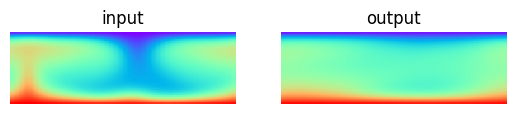

In [52]:
auto_encoder_animation(slice=24, fps=30, frames=1000, feature='t', 
                       axis=0, animation_name='animations/width', 
                       model=model, sim_file=sim_file, device=DEVICE)


Video("animations/width.mp4")

**Depth slice**

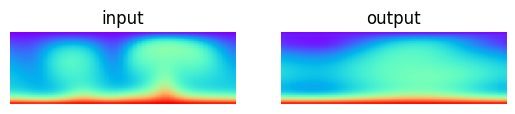

In [ ]:
auto_encoder_animation(slice=24, fps=30, frames=1000, feature='t', 
                       axis=1, animation_name='animations/depth', 
                       model=model, sim_file=sim_file, device=DEVICE)

Video("animations/depth.mp4")

**Height slice**

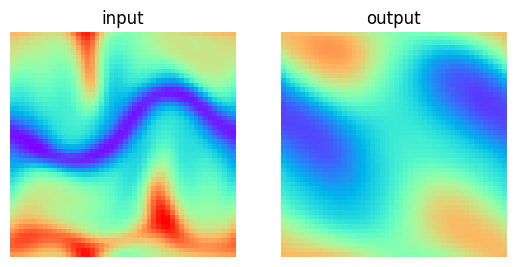

In [54]:
auto_encoder_animation(slice=16, fps=30, frames=1000, feature='t', 
                       axis=2, animation_name='animations/height', 
                       model=model, sim_file=sim_file, device=DEVICE)

Video("animations/height.mp4")